In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import datetime
import pickle

In [2]:
def plotImages(image, predicted_age, real_age):
    plt.figure(figsize=(20,20)) # specifying the overall grid size
    for i in range(25):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        plt.axis('off')
        plt.imshow(image[i])
        x = np.round(predicted_age[i], 2)
        plt.title(f"age: {real_age[i]} pred: {str(x)}")
    plt.show()

In [4]:
# reading the data
path = f"utk-data/cnn"

pickle_in = open(f"{path}/test_image",'rb')
test_image = pickle.load(pickle_in, encoding='bytes')
pickle_in.close()

pickle_out = open(f"{path}/train_image",'rb')
train_image = pickle.load(pickle_out, encoding='bytes')
pickle_out.close()

pickle_out = open(f"{path}/test_age",'rb')
test_age = pickle.load(pickle_out, encoding='bytes')
pickle_out.close()

pickle_out = open(f"{path}/train_age",'rb')
train_age = pickle.load(pickle_out, encoding='bytes')
pickle_out.close()

In [5]:
# shuffling and casting the data to arrays
train_image, train_age = shuffle(train_image, train_age, random_state=0)
test_image, test_age = shuffle(test_image, test_age, random_state=0)

test_image = np.array(test_image)
train_image = np.array(train_image)

test_age = np.array(test_age, dtype = np.uint8)
train_age = np.array(train_age, dtype = np.uint8)

In [6]:
#model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Resizing, Rescaling,RandomZoom, RandomFlip, RandomRotation, RandomBrightness, RandomContrast, RandomTranslation, GaussianNoise
from tensorflow.keras.callbacks import TensorBoard
import datetime


#callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"log: {log_dir}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  restore_best_weights=True)

model = Sequential()

# preprocessing
model.add(Resizing(100,100))
model.add(Rescaling(1./255))

# augmentations
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.2))
model.add(RandomZoom(((-0.1, 00))))
model.add(RandomContrast(0.1))
model.add(GaussianNoise(0.02))

# feature extraction
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
          
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D())

# classification 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='relu'))


model.compile(loss="mae",
               optimizer = "adam",
               metrics =["accuracy"])

# training the model
history = model.fit(train_image,train_age, batch_size=32, epochs = 150, validation_split = 0.1, callbacks = [tensorboard_callback, early_stopping])
          

log: logs/fit/20230126-104758
Epoch 1/150
544/544 [==============================] - 172s 306ms/step - loss: 15.0459 - accuracy: 0.0467 - val_loss: 14.1886 - val_accuracy: 0.0439
Epoch 2/150
544/544 [==============================] - 153s 282ms/step - loss: 13.7046 - accuracy: 0.0468 - val_loss: 13.0732 - val_accuracy: 0.0439
Epoch 3/150
544/544 [==============================] - 154s 284ms/step - loss: 13.0076 - accuracy: 0.0468 - val_loss: 12.6373 - val_accuracy: 0.0439
Epoch 4/150
544/544 [==============================] - 151s 278ms/step - loss: 11.9142 - accuracy: 0.0452 - val_loss: 11.3894 - val_accuracy: 0.0439
Epoch 5/150
544/544 [==============================] - 149s 273ms/step - loss: 10.7606 - accuracy: 0.0460 - val_loss: 11.0104 - val_accuracy: 0.0439
Epoch 6/150
544/544 [==============================] - 151s 277ms/step - loss: 10.1682 - accuracy: 0.0461 - val_loss: 9.7317 - val_accuracy: 0.0439
Epoch 7/150
544/544 [==============================] - 152s 280ms/step - loss

In [ ]:
# saving the model
model.save(f"age_model_cnn")

In [ ]:
# # loading the model
# from keras.models import load_model
# model = load_model(f"age_model_cnn")

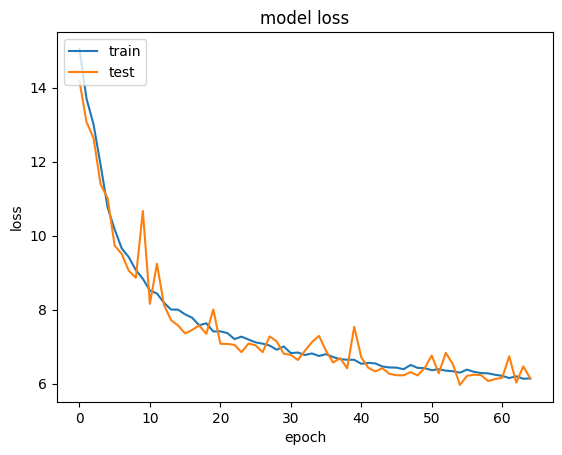

In [9]:
# plotting model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# predictions
prediction = model.predict(x = test_image, batch_size = 10, verbose = 0)

In [11]:
# calculating mae
pred = prediction.flatten()
tes = np.array(test_age)
error=np.subtract(pred, tes)
mae=np.mean(np.abs(error))
mae

6.060783

In [12]:
# calculating mape
pred = prediction.flatten()
tes = np.array(test_age)
error=np.subtract(pred, tes)
error=np.divide(error, tes)
mape=np.mean(np.abs(error))
mape

0.25941285

In [13]:
# choosing predictions with error > 30 years
invalid_prediction = []
invalid_prediction_age = []
invalid_age = []

for i in range(0, len(prediction)):
    if abs(prediction[i] - test_age[i]) > 30:
        invalid_prediction.append(test_image[i])
        invalid_prediction_age.append(prediction[i])
        invalid_age.append(test_age[i])
        
invalid_prediction = np.array(invalid_prediction)
invalid_prediction_age = np.array(invalid_prediction_age, dtype = np.uint8)
invalid_age = np.array(invalid_age, dtype = np.uint8)

IndexError: index 10 is out of bounds for axis 0 with size 10

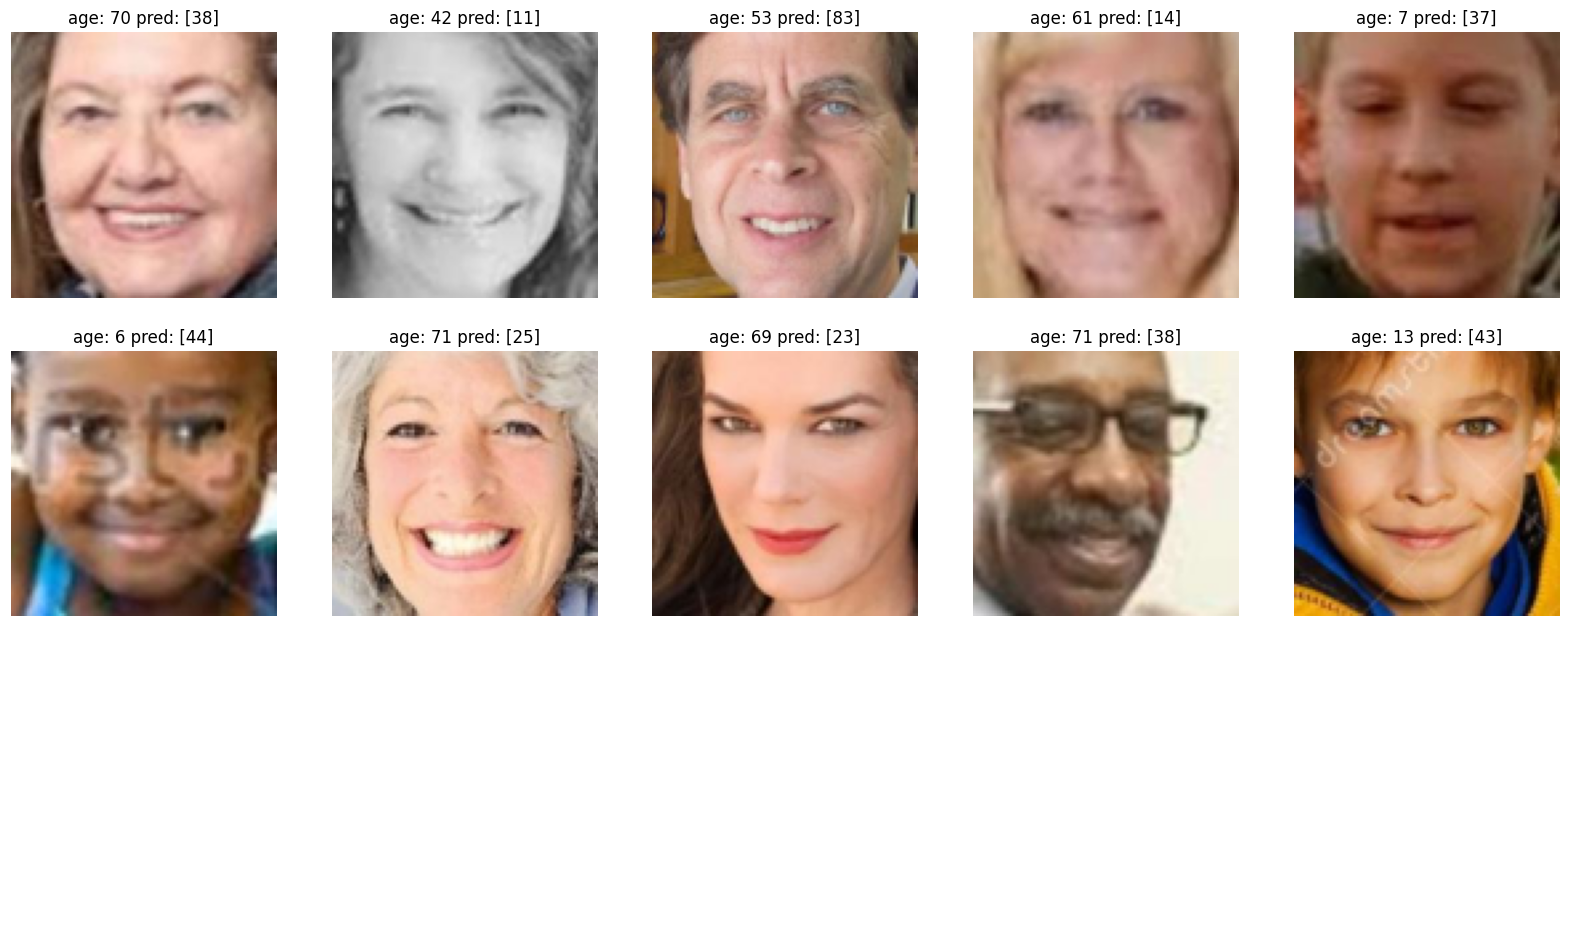

In [14]:
# plotting the images
plotImages(invalid_prediction, invalid_prediction_age, invalid_age)

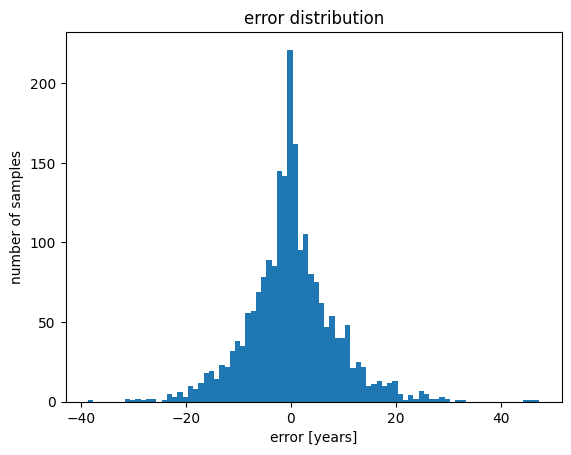

In [15]:
# plotting error distribution
error = test_age - prediction.flatten()
plt.hist(error, bins = np.arange(min(error), max(error) + 1, 1))
plt.title('error distribution')
plt.xlabel('error [years]')
plt.ylabel('number of samples')
plt.show()

In [22]:
# choosing predictions with error > 10 years
invalid_prediction = []
invalid_prediction_age = []
invalid_age = []

for i in range(0, len(prediction)):
    if abs(prediction[i] - test_age[i]) > 10:
        invalid_prediction.append(test_image[i])
        invalid_prediction_age.append(prediction[i])
        invalid_age.append(test_age[i])    
        
invalid_prediction = np.array(invalid_prediction)
invalid_prediction_age = np.array(invalid_prediction_age, dtype = np.uint8)
invalid_age = np.array(invalid_age, dtype = np.uint8)

In [23]:
len(prediction)

2185

In [24]:
len(invalid_age)

441

(array([ 2.,  0.,  4.,  4.,  8.,  5.,  5.,  1.,  4.,  2.,  6.,  4.,  9.,
         5., 10.,  3.,  3.,  4.,  3.,  0.,  3.,  9.,  8.,  3.,  6.,  3.,
         4.,  4.,  8.,  1.,  3., 21.,  8.,  9.,  7., 12., 20.,  2., 11.,
         8.,  1., 13.,  6.,  6.,  6.,  8., 18.,  5.,  8., 15.,  7., 10.,
        10.,  5., 14.,  5.,  8.,  4.,  4.,  3.,  2.,  9.,  4.,  3.,  7.,
         2.,  9.,  2.,  5.,  2.,  8.]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
        17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
        30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
        43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
        69., 70., 71., 72., 73., 74., 75.]),
 <BarContainer object of 71 artists>)

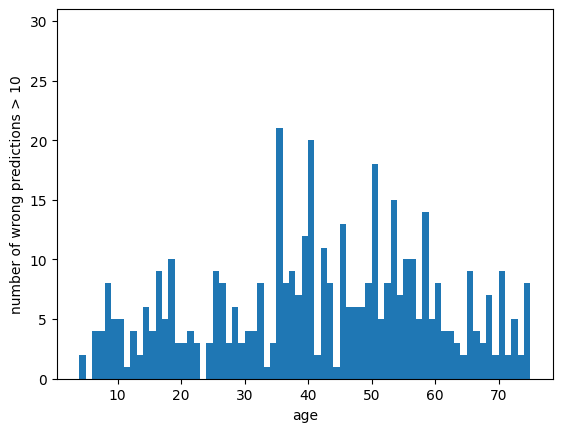

In [39]:
# plotting number of wrong preditions with error > 10 years per each class
plt.xlabel('age')
plt.ylabel('number of wrong predictions > 10')
plt.ylim(0, 31)
plt.hist(invalid_age, bins=71)

<BarContainer object of 75 artists>

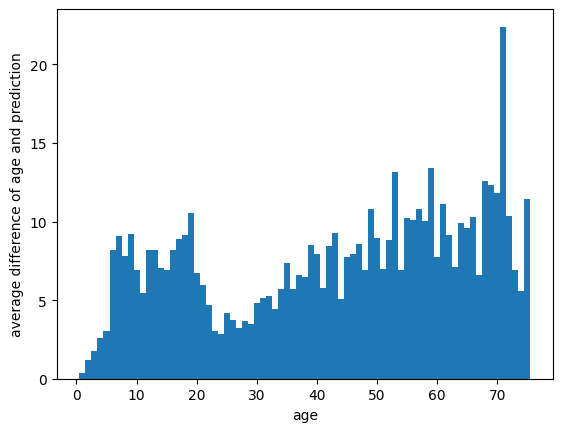

In [31]:
# plotting averae error per class
import numpy as np

errors = np.zeros(75)

for i in range(1, 76):
    indices = np.where(test_age == i)[0]
    error = np.abs(prediction[indices] - test_age[indices]) 
    errors[i-1] = np.sum(error) / error.size

plt.xlabel('age')
plt.ylabel('average difference of age and prediction')
plt.bar(range(1, 76), errors, width=1.0)